---
title: Data Cleaning and EDA
---

::: {note} Learning Outcomes
* Recognize common file formats
* Categorize data by its variable type
* Build awareness of issues with data faithfulness and develop targeted solutions
:::

In the past few lectures, we've learned that `pandas` is a toolkit to restructure, modify, and explore a dataset. What we haven't yet touched on is *how* to make these data transformation decisions. When we receive a new set of data from the "real world," how do we know what processing we should do to convert this data into a usable form?

**Data cleaning**, also called **data wrangling**, is the process of transforming raw data to facilitate subsequent analysis. It is often used to address issues like:

* Unclear structure or formatting
* Missing or corrupted values
* Unit conversions
* ...and so on

**Exploratory Data Analysis (EDA)** is the process of understanding a new dataset. It is an open-ended, informal analysis that involves familiarizing ourselves with the variables present in the data, discovering potential hypotheses, and identifying possible issues with the data. This last point can often motivate further data cleaning to address any problems with the dataset's format; because of this, EDA and data cleaning are often thought of as an "infinite loop," with each process driving the other.

In this lecture, we will consider the key properties of data to consider when performing data cleaning and EDA. In doing so, we'll develop a "checklist" of sorts for you to consider when approaching a new dataset. Throughout this process, we'll build a deeper understanding of this early (but very important!) stage of the data science lifecycle.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
# This option stops scientific notation for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Silence some spurious seaborn warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Structure
We often prefer rectangular data for data analysis. Rectangular structures are easy to manipulate and analyze. A key element of data cleaning is about transforming data to be more rectangular. 

There are two kinds of rectangular data: tables and matrices. Tables have named columns with different data types and are manipulated using data transformation languages. Matrices contain numeric data of the same type and are manipulated using linear algebra.

### File Formats
There are many file types for storing structured data: TSV, JSON, XML, ASCII, SAS, etc. We'll only cover CSV, TSV, and JSON in lecture, but you'll likely encounter other formats as you work with different datasets. Reading documentation is your best bet for understanding how to process the multitude of different file types. 

#### CSV
CSVs, which stand for **Comma-Separated Values**, are a common tabular data format. 
In the past two `pandas` lectures, we briefly touched on the idea of file format: the way data is encoded in a file for storage. Specifically, our `elections` and `babynames` datasets were stored and loaded as CSVs:

In [2]:
pd.read_csv("data/elections.csv").head(5)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20
3,1828,John Quincy Adams,National Republican,500897,loss,43.80
4,1832,Andrew Jackson,Democratic,702735,win,54.57


To better understand the properties of a CSV, let's take a look at the first few rows of the raw data file to see what it looks like before being loaded into a `DataFrame`. We'll use the `repr()` function to return the raw string with its special characters: 

In [3]:
with open("data/elections.csv", "r") as table:
    i = 0
    for row in table:
        print(repr(row))
        i += 1
        if i > 3:
            break

'Year,Candidate,Party,Popular vote,Result,%\n'
'1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21012204\n'
'1824,John Quincy Adams,Democratic-Republican,113142,win,42.78987796\n'
'1828,Andrew Jackson,Democratic,642806,win,56.20392707\n'


Each row, or **record**, in the data is delimited by a newline `\n`. Each column, or **field**, in the data is delimited by a comma `,` (hence, comma-separated!). 

#### TSV

Another common file type is **TSV (Tab-Separated Values)**. In a TSV, records are still delimited by a newline `\n`, while fields are delimited by `\t` tab character. 

Let's check out the first few rows of the raw TSV file. Again, we'll use the `repr()` function so that `print` shows the special characters.

In [4]:
with open("data/elections.txt", "r") as table:
    i = 0
    for row in table:
        print(repr(row))
        i += 1
        if i > 3:
            break

'\ufeffYear\tCandidate\tParty\tPopular vote\tResult\t%\n'
'1824\tAndrew Jackson\tDemocratic-Republican\t151271\tloss\t57.21012204\n'
'1824\tJohn Quincy Adams\tDemocratic-Republican\t113142\twin\t42.78987796\n'
'1828\tAndrew Jackson\tDemocratic\t642806\twin\t56.20392707\n'


TSVs can be loaded into `pandas` using `pd.read_csv`. We'll need to specify the **delimiter** with parameter` sep='\t'` [(documentation)](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [5]:
pd.read_csv("data/elections.txt", sep='\t').head(3)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20


An issue with CSVs and TSVs comes up whenever there are commas or tabs within the records. How does `pandas` differentiate between a comma delimiter vs. a comma within the field itself, for example `8,900`? To remedy this, check out the `quotechar` [parameter](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). 

#### JSON
**JSON (JavaScript Object Notation)** files behave similarly to Python dictionaries. A raw JSON is shown below.

In [6]:
with open("data/elections.json", "r") as table:
    i = 0
    for row in table:
        print(row)
        i += 1
        if i > 8:
            break

[

 {

   "Year": 1824,

   "Candidate": "Andrew Jackson",

   "Party": "Democratic-Republican",

   "Popular vote": 151271,

   "Result": "loss",

   "%": 57.21012204

 },



JSON files can be loaded into `pandas` using `pd.read_json`. 

In [7]:
pd.read_json('data/elections.json').head(3)

,Year,Candidate,Party,Popular vote,Result,%
0,1824,Andrew Jackson,Democratic-Republican,151271,loss,57.21
1,1824,John Quincy Adams,Democratic-Republican,113142,win,42.79
2,1828,Andrew Jackson,Democratic,642806,win,56.20


##### EDA with JSON: United States Congress Data
The congress.gov API (Application Programming Interface) provides data about the activities and members of the United States Congress (i.e., the House of Representatives and the Senate). 

To get a JSON file containing information about the current members of Congress from California, you could use the following **API call**:

- `https://api.congress.gov/v3/member/CA?api_key=[INSERT_KEY]&limit=250&format=json&currentMember=True`

- You can instantly sign up for a congress.gov **API key** [here](https://gpo.congress.gov/sign-up/). Once you have your key, replace `[INSERT_KEY]` above with your key, and enter the API call as a URL in your browser. What happens? 

- Once the JSON from the API call is visible in your browser, you can click `File` --> `Save Page As` to save the JSON file to your coputer.

- Coarsely, API keys are used to track how much a given user engages with the API. There might be limits to the number of API calls (e.g., congress.gov API limits to 5,000 calls per hour), or a cost for API calls (e.g., using the OpenAI API for programmatically using ChatGPT).

After following these steps, we save this JSON file as `data/ca-congress-members.json`. 

###### File Contents
Let's examine this file using Python. We can programmatically view the first couple lines of the file using the same functions we used with CSVs:

In [8]:
congress_file = "data/ca-congress-members.json"

# Inspect the first five lines of the file
with open(congress_file, "r") as f:
    for i, row in enumerate(f):
        print(row)
        if i >= 4: break

{

    "members": [

        {

            "bioguideId": "T000491",

            "depiction": {



###### EDA: Digging into JSON with Python

JSON data closely matches the internal Python object model.  

- In the following cell, we import the entire JSON datafile into a Python dictionary using the `json` package.

In [9]:
import json

# Import the JSON file into Python as a dictionary
with open(congress_file, "rb") as f:
    congress_json = json.load(f)

type(congress_json)

dict

The `congress_json` variable is a dictionary encoding the data in the JSON file.

Below, we access the first element of the `members` element of the `congress_json` dictionary.

- This first element is also a dictionary (and there are more dictionaries inside of it!)

In [10]:
# Grab the list corresponding to the `members` key in the JSON dictionary, 
# and then grab the first element of this list.
# In a moment, we'll see how we knew to use the key `members`, and that
# the resulting object is a list.
congress_json['members'][0]

{'bioguideId': 'T000491',
 'depiction': {'attribution': 'Image courtesy of the Member',
  'imageUrl': 'https://www.congress.gov/img/member/6774606d0b34857ecc9091a9_200.jpg'},
 'district': 45,
 'name': 'Tran, Derek',
 'partyName': 'Democratic',
 'state': 'California',
 'terms': {'item': [{'chamber': 'House of Representatives',
    'startYear': 2025}]},
 'updateDate': '2025-01-21T18:00:52Z',
 'url': 'https://api.congress.gov/v3/member/T000491?format=json'}

How should we probe a nested dictionary like `congress_json`?

We can start by identifying the top-level **keys** of the dictionary:

In [11]:
# Grab the top-level keys of the JSON dictionary
congress_json.keys()

dict_keys(['members', 'pagination', 'request'])

Looks like we have three top-level keys: `members`, `pagination`, and `request`.

> You'll often see a top-level `meta` key in JSON files. This does not refer to Meta (formerly Facebook). Instead, it typically refers to metadata (data about the data).  Metadata are often maintained alongside the data.

Let's check the type of the `members` element:

In [12]:
type(congress_json['members'])

list

Looks like a list! What are the first two elements?

In [13]:
congress_json['members'][:2]

[{'bioguideId': 'T000491',
  'depiction': {'attribution': 'Image courtesy of the Member',
   'imageUrl': 'https://www.congress.gov/img/member/6774606d0b34857ecc9091a9_200.jpg'},
  'district': 45,
  'name': 'Tran, Derek',
  'partyName': 'Democratic',
  'state': 'California',
  'terms': {'item': [{'chamber': 'House of Representatives',
     'startYear': 2025}]},
  'updateDate': '2025-01-21T18:00:52Z',
  'url': 'https://api.congress.gov/v3/member/T000491?format=json'},
 {'bioguideId': 'M001241',
  'depiction': {'attribution': 'Image courtesy of the Member',
   'imageUrl': 'https://www.congress.gov/img/member/67744ed90b34857ecc909155_200.jpg'},
  'district': 47,
  'name': 'Min, Dave',
  'partyName': 'Democratic',
  'state': 'California',
  'terms': {'item': [{'chamber': 'House of Representatives',
     'startYear': 2025}]},
  'updateDate': '2025-01-21T18:00:52Z',
  'url': 'https://api.congress.gov/v3/member/M001241?format=json'}]

More dictionaries! You can repeat the process above to traverse the nested dictionary.

You'll notice that each record of `congress_json['members']` looks like it could be a column of a DataFrame.

- The keys look a lot like column names, and the values could be the entries in each row.

But, the two other elements of `congress_json` don't have the same structure as `congress_json['members']`.

- So, they probably don't belong in a DataFrame containing the members of Congress from CA.

- We'll see the implications of this inconsistency in the next section.

In [14]:
print(congress_json['pagination'])
print(congress_json['request'])

{'count': 54}
{'contentType': 'application/json', 'format': 'json'}


###### JSON with pandas

`pandas` has a built in function called `pd.read_json` for reading in JSON files. In order to read in this JSON file, you might want to try something like the code in the cell below. However, if we tried to run this code, it would error.

In [15]:
# This line intentionally produces an error
pd.read_json(congress_file)

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

- The code above tries to import the entire JSON file located at `congress_file` (`congress_json`), including `congress_json['pagination']` and `congress_json['request']`.

- We only want to make a DataFrame out of `congress_json['members']`.

Instead, let's try converting the `members` element of `congress_json` to a DataFrame by using `pd.DataFrame`:

In [16]:
# Convert dictionary to DataFrame
congress_df = pd.DataFrame(congress_json['members'])
congress_df.head()

,bioguideId,depiction,district,name,partyName,state,terms,updateDate,url
0,T000491,{'attribution': 'Image courtesy of the Member'...,45.00,"Tran, Derek",Democratic,California,{'item': [{'chamber': 'House of Representative...,2025-01-21T18:00:52Z,https://api.congress.gov/v3/member/T000491?for...
1,M001241,{'attribution': 'Image courtesy of the Member'...,47.00,"Min, Dave",Democratic,California,{'item': [{'chamber': 'House of Representative...,2025-01-21T18:00:52Z,https://api.congress.gov/v3/member/M001241?for...
2,K000400,{'attribution': 'Image courtesy of the Member'...,37.00,"Kamlager-Dove, Sydney",Democratic,California,{'item': [{'chamber': 'House of Representative...,2025-01-21T18:00:52Z,https://api.congress.gov/v3/member/K000400?for...
3,G000598,{'attribution': 'Image courtesy of the Member'...,42.00,"Garcia, Robert",Democratic,California,{'item': [{'chamber': 'House of Representative...,2025-01-21T18:00:52Z,https://api.congress.gov/v3/member/G000598?for...
4,K000397,{'attribution': 'Image courtesy of the Member'...,40.00,"Kim, Young",Republican,California,{'item': [{'chamber': 'House of Representative...,2025-01-21T18:00:52Z,https://api.congress.gov/v3/member/K000397?for...


We've successfully begun to rectangularize our JSON data!

### Other Data Formats

So far, we've looked at text data that comes in a quite nice format. Although some data cleaning might be necessary, it has still had all of the components of a rectangular dataset. However, not all data comes like this, and there are also different kinds of data we can use. Some examples include:

* **Image Data**: Used for medical diagnosis
* **Audio Data**: Used for speech recognition, sentiment analysis
* **Video Data**: Used for object tracking, facial recognition
* **Text**: Used for LLMs, document review

Even though this may not look tabular at first, all of these formats can be represented in tabular/matrix form! So by learning how to work with tabular data, you are well equipped to deal with other kinds of data as well.

### Variable Types
Variables are columns. A variable is a measurement of a particular concept. Variables have two common properties: data type/storage type and variable type/feature type. The data type of a variable indicates how each variable value is stored in memory (integer, floating point, boolean, etc.) and affects which `pandas` functions are used. The variable type is a conceptualized measurement of information (and therefore indicates what values a variable can take on). Variable type is identified through expert knowledge, exploring the data itself, or consulting the data codebook. The variable type affects how one visualizes and inteprets the data. In this class, "variable types" are conceptual.

After loading data into a file, it's a good idea to take the time to understand what pieces of information are encoded in the dataset. In particular, we want to identify what variable types are present in our data. Broadly speaking, we can categorize variables into one of two overarching types. 

**Quantitative variables** describe some numeric quantity or amount. Some examples include weights, GPA, CO<sub>2</sub> concentrations, someone's age, or the number of siblings they have.

**Qualitative variables**, also known as **categorical variables**, describe data that isn't measuring some quantity or amount. The sub-categories of categorical data are:

* **Ordinal qualitative variables**: categories with ordered levels. Specifically, ordinal variables are those where the difference between levels has no consistent, quantifiable meaning. Some examples include levels of education (high school, undergrad, grad, etc.), income bracket (low, medium, high), or Yelp rating. 
* **Nominal qualitative variables**: categories with no specific order. For example, someone's political affiliation or Cal ID number.

```{image} images/variable_types.png
:alt: Classification of variable types
:width: 500
```

Note that many variables don't sit neatly in just one of these categories. Qualitative variables could have numeric levels, and conversely, quantitative variables could be stored as strings. 

## Granularity and Temporality

After understanding the structure of the dataset, the next task is to determine what exactly the data represents. We'll do so by considering the data's granularity and temporality.

### Granularity
The **granularity** of a dataset is what a single row represents. You can also think of it as the level of detail included in the data. To determine the data's granularity, ask: what does each row in the dataset represent? Fine-grained data contains a high level of detail, with a single row representing a small individual unit. For example, each record may represent one person. Coarse-grained data is encoded such that a single row represents a large individual unit – for example, each record may represent a group of people.

### Temporality
The **temporality** of a dataset describes the periodicity over which the data was collected as well as when the data was most recently collected or updated. 

Time and date fields of a dataset could represent a few things:

1. when the "event" happened
2. when the data was collected, or when it was entered into the system
3. when the data was copied into the database 

To fully understand the temporality of the data, it also may be necessary to standardize time zones or inspect recurring time-based trends in the data (do patterns recur in 24-hour periods? Over the course of a month? Seasonally?). The convention for standardizing time is the Coordinated Universal Time (UTC), an international time standard measured at 0 degrees latitude that stays consistent throughout the year (no daylight savings). We can represent Berkeley's time zone, Pacific Standard Time (PST), as UTC-7 (with daylight savings). 

#### Temporality with `pandas`' `dt` accessors 
Let's briefly look at how we can use `pandas`' `dt` accessors to work with dates/times in a dataset using the dataset you'll see in Lab 3: the Berkeley PD Calls for Service dataset.

````{dropdown} Click to see the code
:open: false
```
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()
```
````

In [17]:
calls = pd.read_csv("data/Berkeley_PD_-_Calls_for_Service.csv")
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,21014296,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\r\n(37.869058, -122.270455)",NaN,Berkeley,CA
1,21014391,THEFT MISD. (UNDER $950),04/01/2021 12:00:00 AM,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\r\n(37.869058, -122.270455)",NaN,Berkeley,CA
2,21090494,THEFT MISD. (UNDER $950),04/19/2021 12:00:00 AM,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\r\nBerkeley, CA\r\n(37.864...",2100 BLOCK HASTE ST,Berkeley,CA
3,21090204,THEFT FELONY (OVER $950),02/13/2021 12:00:00 AM,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\r\nBerkeley, CA\r\n(37.8...",2600 BLOCK WARRING ST,Berkeley,CA
4,21090179,BURGLARY AUTO,02/08/2021 12:00:00 AM,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\r\nBerkeley, CA\r\n(37.86...",2700 BLOCK GARBER ST,Berkeley,CA


Looks like there are three columns with dates/times: `EVENTDT`, `EVENTTM`, and `InDbDate`. 

Most likely, `EVENTDT` stands for the date when the event took place, `EVENTTM` stands for the time of day the event took place (in 24-hr format), and `InDbDate` is the date this call is recorded onto the database.

If we check the data type of these columns, we will see they are stored as strings. We can convert them to `datetime` objects using pandas `to_datetime` function.

In [18]:
calls["EVENTDT"] = pd.to_datetime(calls["EVENTDT"])
calls.head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
0,21014296,THEFT MISD. (UNDER $950),2021-04-01,10:58,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\r\n(37.869058, -122.270455)",NaN,Berkeley,CA
1,21014391,THEFT MISD. (UNDER $950),2021-04-01,10:38,LARCENY,4,06/15/2021 12:00:00 AM,"Berkeley, CA\r\n(37.869058, -122.270455)",NaN,Berkeley,CA
2,21090494,THEFT MISD. (UNDER $950),2021-04-19,12:15,LARCENY,1,06/15/2021 12:00:00 AM,"2100 BLOCK HASTE ST\r\nBerkeley, CA\r\n(37.864...",2100 BLOCK HASTE ST,Berkeley,CA
3,21090204,THEFT FELONY (OVER $950),2021-02-13,17:00,LARCENY,6,06/15/2021 12:00:00 AM,"2600 BLOCK WARRING ST\r\nBerkeley, CA\r\n(37.8...",2600 BLOCK WARRING ST,Berkeley,CA
4,21090179,BURGLARY AUTO,2021-02-08,6:20,BURGLARY - VEHICLE,1,06/15/2021 12:00:00 AM,"2700 BLOCK GARBER ST\r\nBerkeley, CA\r\n(37.86...",2700 BLOCK GARBER ST,Berkeley,CA


Now, we can use the `dt` accessor on this column.

We can get the month: 

In [19]:
calls["EVENTDT"].dt.month.head()

0    4
1    4
2    4
3    2
4    2
Name: EVENTDT, dtype: int32

Which day of the week the date is on:

In [20]:
calls["EVENTDT"].dt.dayofweek.head()

0    3
1    3
2    0
3    5
4    0
Name: EVENTDT, dtype: int32

Check the minimum values to see if there are any suspicious-looking, 70s dates:

In [21]:
calls.sort_values("EVENTDT").head()

,CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
2513,20057398,BURGLARY COMMERCIAL,2020-12-17,16:05,BURGLARY - COMMERCIAL,4,06/15/2021 12:00:00 AM,"600 BLOCK GILMAN ST\r\nBerkeley, CA\r\n(37.878...",600 BLOCK GILMAN ST,Berkeley,CA
624,20057207,ASSAULT/BATTERY MISD.,2020-12-17,16:50,ASSAULT,4,06/15/2021 12:00:00 AM,"2100 BLOCK SHATTUCK AVE\r\nBerkeley, CA\r\n(37...",2100 BLOCK SHATTUCK AVE,Berkeley,CA
154,20092214,THEFT FROM AUTO,2020-12-17,18:30,LARCENY - FROM VEHICLE,4,06/15/2021 12:00:00 AM,"800 BLOCK SHATTUCK AVE\r\nBerkeley, CA\r\n(37....",800 BLOCK SHATTUCK AVE,Berkeley,CA
659,20057324,THEFT MISD. (UNDER $950),2020-12-17,15:44,LARCENY,4,06/15/2021 12:00:00 AM,"1800 BLOCK 4TH ST\r\nBerkeley, CA\r\n(37.86988...",1800 BLOCK 4TH ST,Berkeley,CA
993,20057573,BURGLARY RESIDENTIAL,2020-12-17,22:15,BURGLARY - RESIDENTIAL,4,06/15/2021 12:00:00 AM,"1700 BLOCK STUART ST\r\nBerkeley, CA\r\n(37.85...",1700 BLOCK STUART ST,Berkeley,CA


Doesn't look like it! We are good!

We can also do many things with the `dt` accessor like switching time zones and converting time back to UNIX/POSIX time. Check out the documentation on `.dt` [accessor](https://pandas.pydata.org/docs/user_guide/basics.html#basics-dt-accessors) and [time series/date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html#).

## Faithfulness

At this stage in our data cleaning and EDA workflow, we've achieved quite a lot: we've identified how our data is structured, come to terms with what information it encodes, and gained insight as to how it was generated. Throughout this process, we should always recall the original intent of our work in Data Science – to use data to better understand and model the real world. To achieve this goal, we need to ensure that the data we use is faithful to reality; that is, that our data accurately captures the "real world."

Data used in research or industry is often "messy" – there may be errors or inaccuracies that impact the faithfulness of the dataset. Signs that data may not be faithful include:

* Unrealistic or "incorrect" values, such as negative counts, locations that don't exist, or dates set in the future
* Violations of obvious dependencies, like an age that does not match a birthday
* Clear signs that data was entered by hand, which can lead to spelling errors or fields that are incorrectly shifted
* Signs of data falsification, such as fake email addresses or repeated use of the same names
* Duplicated records or fields containing the same information
* Truncated data, e.g. Microsoft Excel would limit the number of rows to 655536 and the number of columns to 255

We often solve some of these more common issues in the following ways: 

* Spelling errors: apply corrections or drop records that aren't in a dictionary
* Time zone inconsistencies: convert to a common time zone (e.g. UTC) 
* Duplicated records or fields: identify and eliminate duplicates (using primary keys)
* Unspecified or inconsistent units: infer the units and check that values are in reasonable ranges in the data

### Missing Values
Another common issue encountered with real-world datasets is that of missing data. One strategy to resolve this is to simply drop any records with missing values from the dataset. This does, however, introduce the risk of inducing biases – it is possible that the missing or corrupt records may be systemically related to some feature of interest in the data. This is why it's generally good practice to keep missing data, or at least to only drop if it you can be sure the missing data won't introduce some bias. Another solution is to keep the data as `NaN` values.

A third method to address missing data is to perform **imputation**: infer the missing values using other data available in the dataset. There is a wide variety of imputation techniques that can be implemented; some of the most common are listed below.

* Average imputation: replace missing values with the average value for that field
* Hot deck imputation: replace missing values with some random value
* Regression imputation: develop a model to predict missing values and replace with the predicted value from the model.
* Multiple imputation: replace missing values with multiple random values

Regardless of the strategy used to deal with missing data, we should think carefully about *why* particular records or fields may be missing – this can help inform whether or not the absence of these values is significant or meaningful.

**Note: In Spring 2026, interpolation is out of scope for Data 100.**

## EDA Demo 1: Flu in the United States

Now, let's walk through the data-cleaning and EDA workflow to see what can we learn about the presence of flu in the United States!

We will examine the data included in the [original CDC database](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html), which we downloaded in 2026.


### CSVs and Field Names
Suppose this dataset was saved as a CSV file located in `data/flu/`.

We can then explore the CSV (which is a text file, and does not contain binary-encoded data) in many ways:
1. Using a text editor like VSCode, emacs, vim, etc.
2. Opening the CSV directly in DataHub (read-only), Excel, Google Sheets, etc.
3. The `Python` file object
4. `pandas`, using `pd.read_csv()`

To try out options 1 and 2, you can view or download the flu data from the [lecture demo notebook](https://data100.datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FDS-100%2Fsp26-student&branch=main&urlpath=lab%2Ftree%2Fsp26-student%2Flec%2Flec05%2Flec05-part-1-eda-tuberculosis.ipynb) under the `data` folder in the left hand menu. Notice how the CSV file is a type of **rectangular data (i.e., tabular data) stored as comma-separated values**.

Next, let's try out option 3 using the `Python` file object. We'll look at the first four lines:

````{dropdown} Click to see the code
:open: false
```
with open("data/flu/ILINet.csv", "r") as f:
    i = 0
    for row in f:
        print(row)
        i += 1
        if i > 3:
            break
```
````

In [22]:
with open("data/flu/ILINet.csv", "r") as f:
    i = 0
    for row in f:
        print(row)
        i += 1
        if i > 3:
            break

PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS

REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS

HHS Regions,Region 1,2015,40,0.743302,0.684364,103,50,,133,23,13,322,134,47051

HHS Regions,Region 2,2015,40,1.03278,1.22475,547,294,,528,123,95,1587,199,129577



Whoa, why are there blank lines interspaced between the lines of the CSV?

You may recall that all line breaks in text files are encoded as the special newline character `\n`. Python's `print()` prints each string (including the newline), and an additional newline on top of that.

If you're curious, we can use the `repr()` function to return the raw string with all special characters:

````{dropdown} Click to see the code
:open: false
```
with open("data/flu/ILINet.csv", "r") as f:
    i = 0
    for row in f:
        print(repr(row)) # print raw strings
        i += 1
        if i > 3:
            break
```
````

In [23]:
with open("data/flu/ILINet.csv", "r") as f:
    i = 0
    for row in f:
        print(repr(row)) # print raw strings
        i += 1
        if i > 3:
            break

'PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS\n'
'REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS\n'
'HHS Regions,Region 1,2015,40,0.743302,0.684364,103,50,,133,23,13,322,134,47051\n'
'HHS Regions,Region 2,2015,40,1.03278,1.22475,547,294,,528,123,95,1587,199,129577\n'


Finally, let's try option 4 and use the tried-and-true Data 100 approach: `pandas`.

In [24]:
ili = pd.read_csv("data/flu/ILINet.csv")
ili

PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS
REGION TYPE REGION    YEAR WEEK % WEIGHTED ILI %UNWEIGHTED ILI AGE 0-4 AGE 25-49 AGE 25-64 AGE 5-24 AGE 50-64 AGE 65 ILITOTAL NUM. OF PROVIDERS                                     TOTAL PATIENTS                            
HHS Regions Region 1  2015 40   0.743302       0.684364        103     50        NaN       133      23        13     322      134                                                            47051                            
            Region 2  2015 40   1.03278        1.22475         547     294       NaN       528      123       95     1587     199                                                           129577                            
            Region 3  2015 40   1.2178         1.24313         401     419       NaN       625      144       81     1670     280                                                           134338                            
            Region 4  2015 40   1.01464        1.15781         486     231       NaN       613      99        75     1504     299                                                           129900                            
...                                                                                                                                                                                            ...                            
            Region 6  2026 3    6.71907        6.40685         1189    1313      NaN       2393     451       375    5721     205                                                            89295                            
            Region 7  2026 3    5.70345        5.79518         518     722       NaN       1174     228       338    2980     164                                                            51422                            
            Region 8  2026 3    3.03915        3.08624         684     670       NaN       1000     246       289    2889     228                                                            93609                            
            Region 9  2026 3    4.85718        4.62364         2045    5863      NaN       4914     2552      3004   18378    402                                                           397479                            
            Region 10 2026 3    5.06699        4.91184         1462    1946      NaN       3526     700       793    8427     332                                                           171565                            

[5381 rows x 1 columns]

You may notice some strange things about this table: why is there only one column, and what is happening with column labels?

Congratulations — you're ready to wrangle your data! Because of how things are stored, we'll need to clean the data a bit to name our columns better.

A reasonable first step is to identify the row with the right header. The `pd.read_csv()` function ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)) has the convenient `header` parameter that we can set to use the elements in row 1 as the appropriate columns:

In [25]:
ili = pd.read_csv("data/flu/ILINet.csv", header=1) # row index
ili.head(5)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,HHS Regions,Region 1,2015,40,0.74,0.68,103,50,NaN,133,23,13,322,134,47051
1,HHS Regions,Region 2,2015,40,1.03,1.22,547,294,NaN,528,123,95,1587,199,129577
2,HHS Regions,Region 3,2015,40,1.22,1.24,401,419,NaN,625,144,81,1670,280,134338
3,HHS Regions,Region 4,2015,40,1.01,1.16,486,231,NaN,613,99,75,1504,299,129900
4,HHS Regions,Region 5,2015,40,1.04,1.18,384,238,NaN,444,159,103,1328,284,112807


### Granularity of the records
After successfully opening the CSV file, we can examine the granularity of each record in our flu dataset. By inspecting the data, we see that each row represents a unique combination of **week**, **year**, and **region**.

Now that we have the data in a DataFrame and understand what each row represents, we can start thinking about **visualizations**: a picture is always worth a thousand words.

### Visualization

#### Preprocessing and column manipulation

We know that our data records observations over a period of time and is separated by region, so a line plot is a reasonable choice due to its ability to effectively display trends over time and allow for easy comparison across regions.

However, `YEAR` and `WEEK` are in two separate columns, so we need to combine them into a single datetime column for the x-axis. Here, the `pd.to_datetime()` function mentioned earlier could help us. The details of how we construct the format here aren't as important as the end result. This is a great use case for a google search or asking an LLM.

In [26]:
ili['week_start'] = pd.to_datetime(
    (ili['YEAR'] * 100 + ili['WEEK']).astype(str) + '0', 
    format='%Y%W%w'
)
ili.sample(3)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,week_start
1856,HHS Regions,Region 7,2019,17,0.99,1.08,136,43,NaN,106,25,33,343,109,31807,2019-05-05
4421,HHS Regions,Region 2,2024,13,3.51,4.61,1573,2948,NaN,3310,731,517,9079,245,196943,2024-03-31
169,HHS Regions,Region 10,2016,4,1.41,1.50,55,37,NaN,92,23,4,211,76,14029,2016-01-31


We can access datetime components using the .dt accessor, for example .dt.year and .dt.month.

In [27]:
ili['week_start'].dt.year.head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: week_start, dtype: int32

Here, we can spend some time to look at what is the data type of the new column.

In [28]:
ili['week_start'].dtype

dtype('<M8[ns]')

`ns` above stands for nanoseconds.

- `<M8` refers to the Numpy type `datetime64`

Under the hood, datetimes in Pandas are integers representing the number of **nanoseconds** since 1/1/1970 UTC.

#### Plotting
We will dive deeper into the details of data visualization later, but for now this is a sneak peek at what we will be able to do in the future!

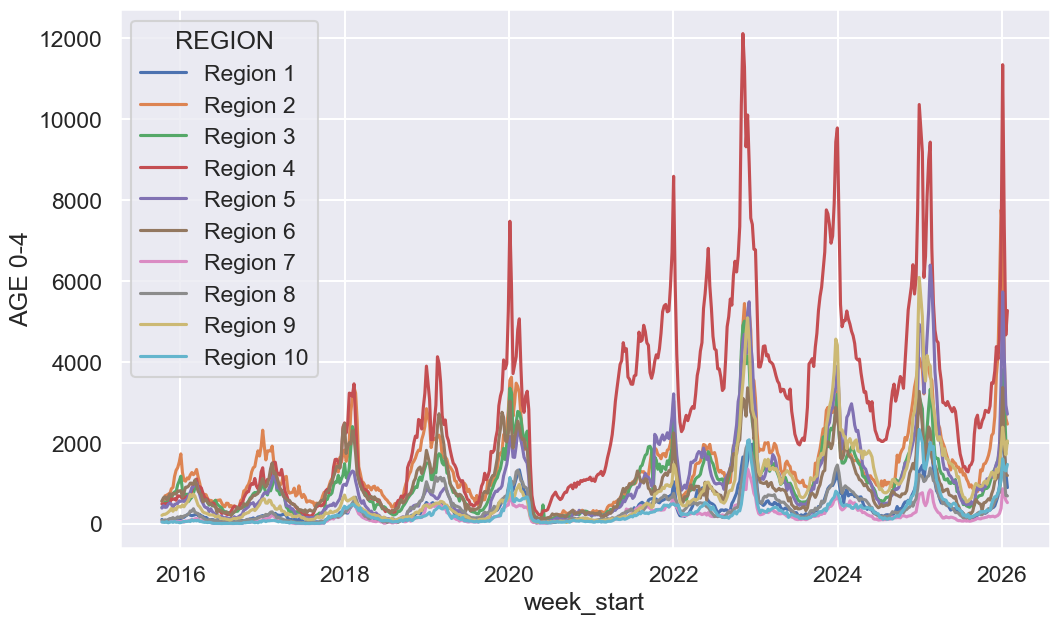

In [29]:
# Visualize number of cases for babies and small children

f, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(ili, x='week_start', y='AGE 0-4', hue='REGION', ax=ax);

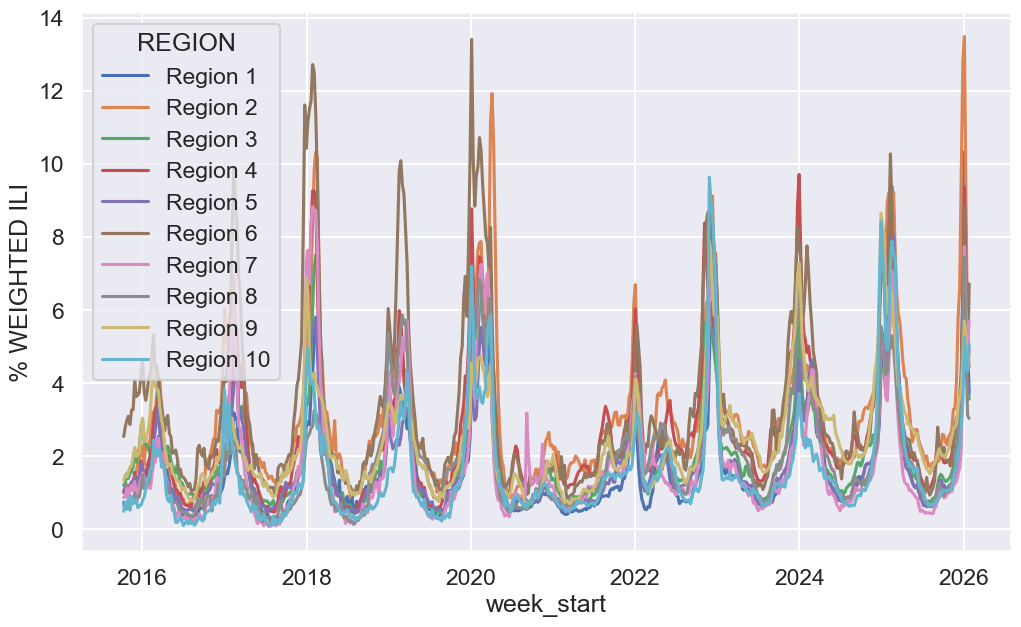

In [30]:
# Visualize overall prevalence of flu
f, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.lineplot(ili, x='week_start', y='% WEIGHTED ILI', hue='REGION', ax=ax);

Take some time to examine it and consider any interesting observations or questions that arise from the data. We will explore data visualization in much more depth in upcoming lectures.

### Load vaccination data
This DataFrame contains monthly flu vaccination counts for each flu season (starting in July and ending the following June).

Take a close look at the output, and make sure you understand what happens between 2023-06-01 and 2023-07-01!


In [31]:
vax = pd.read_csv('data/flu/monthly_child_flu_vaccination.csv')
vax['month_dt'] = pd.to_datetime(vax['month_dt'])
vax['rate'] = vax['Numerator'] / vax['Population']
vax.head(14)

,HHS Region,month_dt,Numerator,Population,rate
0,Region 1,2022-07-01,17110.00,1328581.00,0.01
1,Region 1,2022-08-01,42110.00,1328581.00,0.03
2,Region 1,2022-09-01,129698.00,1328581.00,0.10
3,Region 1,2022-10-01,297855.00,1328581.00,0.22
4,Region 1,2022-11-01,430376.00,1328581.00,0.32
5,Region 1,2022-12-01,508781.00,1328581.00,0.38
6,Region 1,2023-01-01,545783.00,1328581.00,0.41
7,Region 1,2023-02-01,563456.00,1328581.00,0.42
8,Region 1,2023-03-01,575885.00,1328581.00,0.43
9,Region 1,2023-04-01,581451.00,1328581.00,0.44


### Joining Data (Merging different `DataFrame`)
First, let's examine the two `DataFrame` we are merging.



In [32]:
display(ili.tail(2))
display(vax.tail(2))

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,week_start
5378,HHS Regions,Region 9,2026,3,4.86,4.62,2045,5863,NaN,4914,2552,3004,18378,402,397479,2026-01-25
5379,HHS Regions,Region 10,2026,3,5.07,4.91,1462,1946,NaN,3526,700,793,8427,332,171565,2026-01-25


,HHS Region,month_dt,Numerator,Population,rate
418,Region 9,2025-11-01,1416002.00,8216613.00,0.17
419,Region 9,2025-12-01,1686327.00,8216613.00,0.21


This is a natural point to pause and consider how weekly timestamps should be aggregated in order to match the monthly granularity of the vaccination data. In this example, we choose to associate each week with the month in which its start date falls. This isn't the only way we could do this, and it also isn't perfect: there may be weeks that are split across two months where the numbers won't match up exactly.

In [33]:
ili["month"] = ili["week_start"].dt.to_period("M").dt.to_timestamp()

Time to `merge`! Here we use the `DataFrame` method `df1.merge(right=df2, ...)` on `DataFrame df1` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)). Contrast this with the function `pd.merge(left=df1,right=df2, ...)`([documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html#pandas.merge)). Feel free to use either.

In [34]:
ili_vax = ili.merge(
    vax, 
    left_on=['month', 'REGION'], 
    right_on=['month_dt', 'HHS Region']
)
ili_vax.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,week_start,month,HHS Region,month_dt,Numerator,Population,rate
0,HHS Regions,Region 1,2022,26,0.93,1.02,440,356,NaN,346,166,211,1519,232,148833,2022-07-03,2022-07-01,Region 1,2022-07-01,17110.00,1328581.00,0.01
1,HHS Regions,Region 2,2022,26,2.80,2.50,1756,630,NaN,1124,278,297,4085,161,163656,2022-07-03,2022-07-01,Region 2,2022-07-01,699.00,1982009.00,0.00
2,HHS Regions,Region 3,2022,26,1.39,1.63,1347,883,NaN,929,397,360,3916,371,240707,2022-07-03,2022-07-01,Region 3,2022-07-01,284.00,4301556.00,0.00
3,HHS Regions,Region 4,2022,26,2.29,2.47,4320,3555,NaN,3430,1469,1370,14144,928,572466,2022-07-03,2022-07-01,Region 4,2022-07-01,2268.00,13203279.00,0.00
4,HHS Regions,Region 5,2022,26,1.15,1.06,1001,678,NaN,817,331,349,3176,610,300270,2022-07-03,2022-07-01,Region 5,2022-07-01,662.00,11492529.00,0.00


We often merge datasets to get a much bigger picture of what’s really happening in the data—and one of the best ways to showcase that bigger picture is through a bigger visualization!

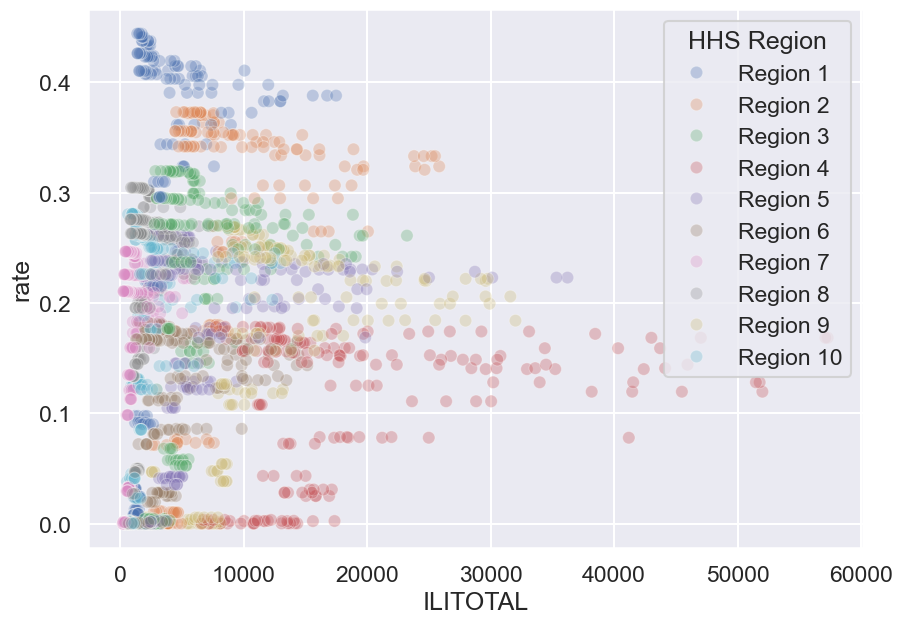

In [35]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.scatterplot(ili_vax, x='ILITOTAL', y='rate', alpha=0.3, hue='HHS Region', ax=ax);

Hmm, this graph appears to show more information than the line plot we examined earlier, but something seems off. What are some limitations of this graph? We will explore what makes an effective visualization in more detail later.

## Summary
We went over a lot of content this lecture; let's summarize the most important points: 

### Dealing with Missing Values
There are a few options we can take to deal with missing data:

* Drop missing records
* Keep `NaN` missing values
* Impute using an interpolated column

### EDA and Data Wrangling
There are several ways to approach EDA and Data Wrangling: 

* Examine the **data and metadata**: what is the date, size, organization, and structure of the data? 
* Examine each **field/attribute/dimension** individually.
* Examine pairs of related dimensions (e.g. breaking down grades by major).
* Along the way, we can:
    * **Visualize** or summarize the data.
    * **Validate assumptions** about data and its collection process. Pay particular attention to when the data was collected. 
    * Identify and **address anomalies**.
    * Apply data transformations and corrections (we'll cover this in the upcoming lecture).
    * **Record everything you do!** Developing in Jupyter Notebook promotes *reproducibility* of your own work!

## [BONUS] EDA Demo 2: Mauna Loa CO<sub>2</sub> Data – A Lesson in Data Faithfulness

We no longer cover the following demo in lecture, but we provide the following section in the course notes for interested students.

[Mauna Loa Observatory](https://gml.noaa.gov/ccgg/trends/data.html) has been monitoring CO<sub>2</sub> concentrations since 1958.

In [36]:
co2_file = "data/co2_mm_mlo.txt"

Let's do some **EDA**!!

### Reading this file into `Pandas`?
Let's instead check out this `.txt` file. Some questions to keep in mind: Do we trust this file extension? What structure is it? 

Lines 71-78 (inclusive) are shown below: 

    line number |                            file contents
    
    71          |   #            decimal     average   interpolated    trend    #days
    72          |   #             date                             (season corr)
    73          |   1958   3    1958.208      315.71      315.71      314.62     -1
    74          |   1958   4    1958.292      317.45      317.45      315.29     -1
    75          |   1958   5    1958.375      317.50      317.50      314.71     -1
    76          |   1958   6    1958.458      -99.99      317.10      314.85     -1
    77          |   1958   7    1958.542      315.86      315.86      314.98     -1
    78          |   1958   8    1958.625      314.93      314.93      315.94     -1


Notice how: 

- The values are separated by white space, possibly tabs.
- The data line up down the rows. For example, the month appears in 7th to 8th position of each line.
- The 71st and 72nd lines in the file contain column headings split over two lines.

We can use `read_csv` to read the data into a `pandas` `DataFrame`, and we provide several arguments to specify that the separators are white space, there is no header (**we will set our own column names**), and to skip the first 72 rows of the file.

In [37]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+'       #delimiter for continuous whitespace (stay tuned for regex next lecture))
)
co2.head()

,0,1,2,3,4,5,6
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


Congratulations! You've wrangled the data!

...But our columns aren't named.
**We need to do more EDA.**

### Exploring Variable Feature Types

The NOAA [webpage](https://gml.noaa.gov/ccgg/trends/) might have some useful tidbits (in this case it doesn't).

Using this information, we'll rerun `pd.read_csv`, but this time with some **custom column names.**

In [38]:
co2 = pd.read_csv(
    co2_file, header = None, skiprows = 72,
    sep = r'\s+', #regex for continuous whitespace (next lecture)
    names = ['Yr', 'Mo', 'DecDate', 'Avg', 'Int', 'Trend', 'Days']
)
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


### Visualizing CO<sub>2</sub>
Scientific studies tend to have very clean data, right...? Let's jump right in and make a time series plot of CO<sub>2</sub> monthly averages.

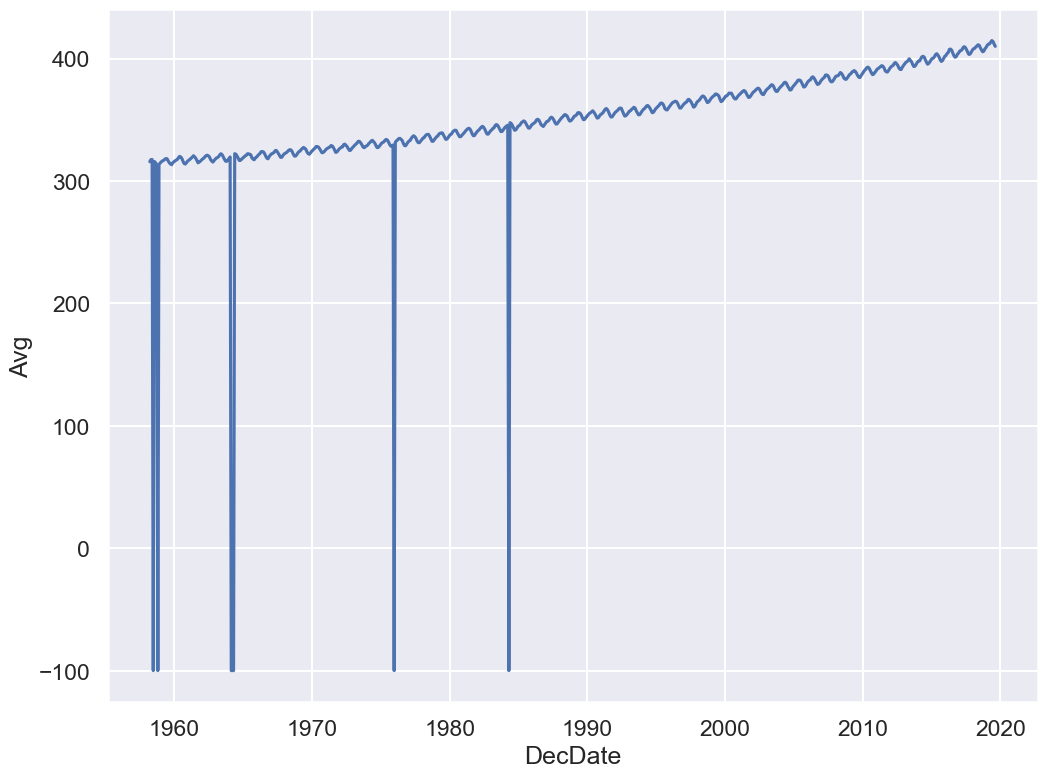

In [39]:
#| fig-alt: A lineplot of the monthly averages from the 1960s to the 1980s. The data mostly has a repeating wave pattern and is larger as time goes on. However, there are a number of large dips to -100.
sns.lineplot(x='DecDate', y='Avg', data=co2);

The code above uses the `seaborn` plotting library (abbreviated `sns`). We will cover this in the Visualization lecture, but now you don't need to worry about how it works!

Yikes! Plotting the data uncovered a problem. The sharp vertical lines suggest that we have some **missing values**. What happened here?

In [40]:
co2.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,-99.99,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


In [41]:
co2.tail()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
733,2019,4,2019.29,413.32,413.32,410.49,26
734,2019,5,2019.38,414.66,414.66,411.20,28
735,2019,6,2019.46,413.92,413.92,411.58,27
736,2019,7,2019.54,411.77,411.77,411.43,23
737,2019,8,2019.62,409.95,409.95,411.84,29


Some data have unusual values like -1 and -99.99.

Let's check the description at the top of the file again.

* -1 signifies a missing value for the number of days `Days` the equipment was in operation that month.
* -99.99 denotes a missing monthly average `Avg`

How can we fix this? First, let's explore other aspects of our data. Understanding our data will help us decide what to do with the missing values.

### Sanity Checks: Reasoning about the data
First, we consider the shape of the data. How many rows should we have?

* If chronological order, we should have one record per month.
* Data from March 1958 to August 2019.
* We should have $ 12 \times (2019-1957) - 2 - 4 = 738 $ records.

In [42]:
co2.shape

(738, 7)

Nice!! The number of rows (i.e. records) match our expectations.

Let's now check the quality of each feature.

### Understanding Missing Value 1: `Days`
`Days` is a time field, so let's analyze other time fields to see if there is an explanation for missing values of days of operation.

Let's start with **months**, `Mo`.

Are we missing any records? The number of months should have 62 or 61 instances (March 1957-August 2019).

In [43]:
co2["Mo"].value_counts().sort_index()

Mo
1     61
2     61
3     62
4     62
5     62
6     62
7     62
8     62
9     61
10    61
11    61
12    61
Name: count, dtype: int64

As expected Jan, Feb, Sep, Oct, Nov, and Dec have 61 occurrences and the rest 62.

Next let's explore **days** `Days` itself, which is the number of days that the measurement equipment worked.

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: Plotted distribution of days feature.
sns.displot(co2['Days']);
plt.title("Distribution of days feature"); # suppresses unneeded plotting output
```
````

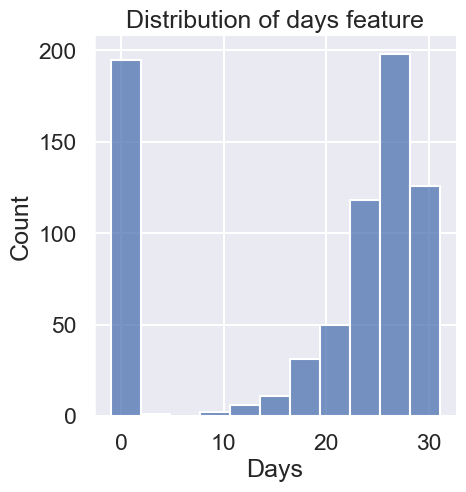

In [44]:
#| fig-alt: Plotted distribution of days feature.
sns.displot(co2['Days']);
plt.title("Distribution of days feature"); # suppresses unneeded plotting output

In terms of data quality, a handful of months have averages based on measurements taken on fewer than half the days. In addition, there are nearly 200 missing values--**that's about 27% of the data**!

Finally, let's check the last time feature, **year** `Yr`.

Let's check to see if there is any connection between missing-ness and the year of the recording.

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: Scatterplot where day is plotted against year. The lowest values are seen in the 1960s and 1970s. By 1990, most years have days plotted at 20 or above.
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output
```
````

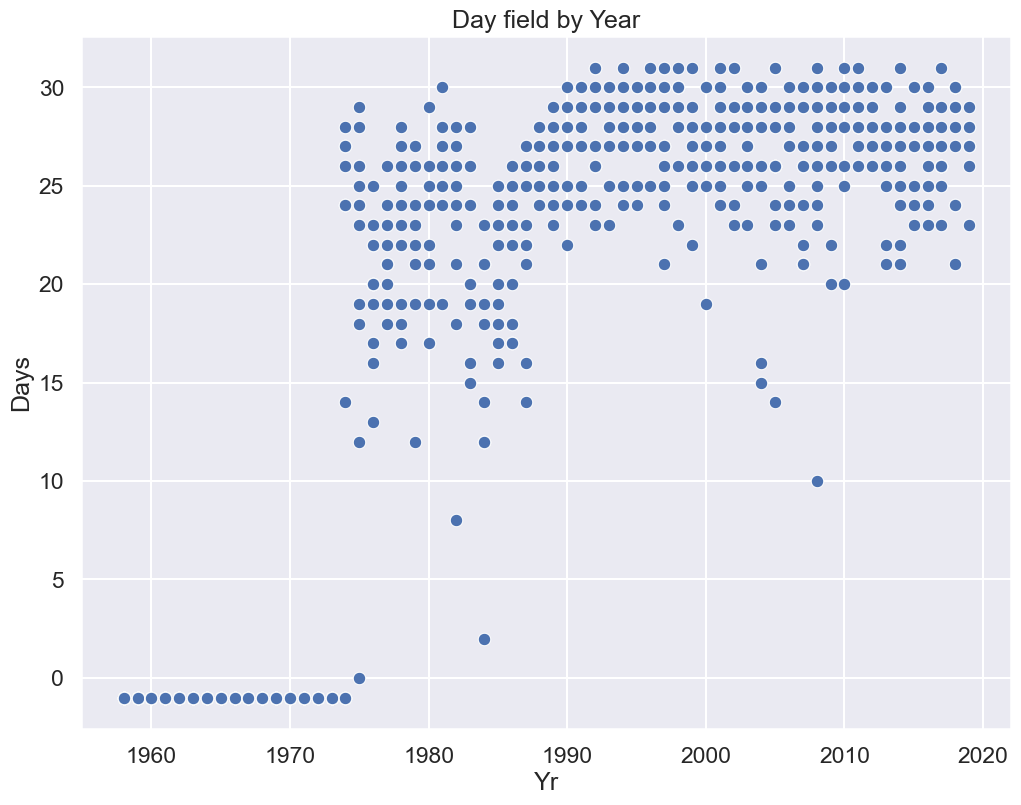

In [45]:
#| fig-alt: Scatterplot where day is plotted against year. The lowest values are seen in the 1960s and 1970s. By 1990, most years have days plotted at 20 or above.
sns.scatterplot(x="Yr", y="Days", data=co2);
plt.title("Day field by Year"); # the ; suppresses output

**Observations**:

* All of the missing data are in the early years of operation.
* It appears there may have been problems with equipment in the mid to late 80s.

**Potential Next Steps**:

* Confirm these explanations through documentation about the historical readings.
* Maybe drop the earliest recordings? However, we would want to delay such action until after we have examined the time trends and assess whether there are any potential problems.

### Understanding Missing Value 2: `Avg`
Next, let's return to the -99.99 values in `Avg` to analyze the overall quality of the CO<sub>2</sub> measurements. We'll plot a histogram of the average CO<sub>2</sub> measurements

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: Histogram of average CO2 measurements. Most of the data is near 400, though there is a bin with data with AVG less than 0.
# Histograms of average CO2 measurements
sns.displot(co2['Avg']);
```
````

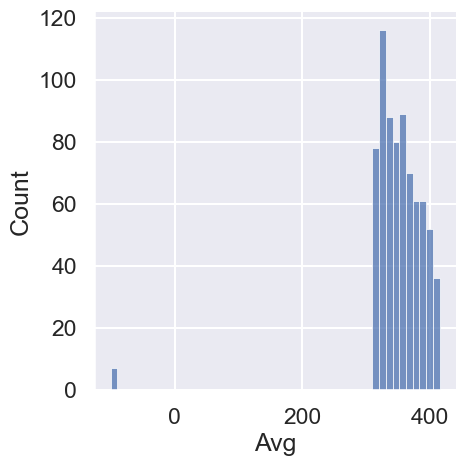

In [46]:
#| fig-alt: Histogram of average CO2 measurements. Most of the data is near 400, though there is a bin with data with AVG less than 0.
# Histograms of average CO2 measurements
sns.displot(co2['Avg']);

The non-missing values are in the 300-400 range (a regular range of CO<sub>2</sub> levels).

We also see that there are only a few missing `Avg` values (**<1% of values**). Let's examine all of them:

In [47]:
co2[co2["Avg"] < 0]

,Yr,Mo,DecDate,Avg,Int,Trend,Days
3,1958,6,1958.46,-99.99,317.10,314.85,-1
7,1958,10,1958.79,-99.99,312.66,315.61,-1
71,1964,2,1964.12,-99.99,320.07,319.61,-1
72,1964,3,1964.21,-99.99,320.73,319.55,-1
73,1964,4,1964.29,-99.99,321.77,319.48,-1
213,1975,12,1975.96,-99.99,330.59,331.60,0
313,1984,4,1984.29,-99.99,346.84,344.27,2


There doesn't seem to be a pattern to these values, other than that most records also were missing `Days` data.

### Drop, `NaN`, or Impute Missing `Avg` Data?

How should we address the invalid `Avg` data?

1. Drop records
2. Set to NaN
3. Impute using some strategy

Remember we want to fix the following plot:

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: A lineplot of the monthly averages from the 1960s to the 1980s. The data mostly has a repeating wave pattern and is larger as time goes on. However, there are a number of large dips to -100.
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");
```
````

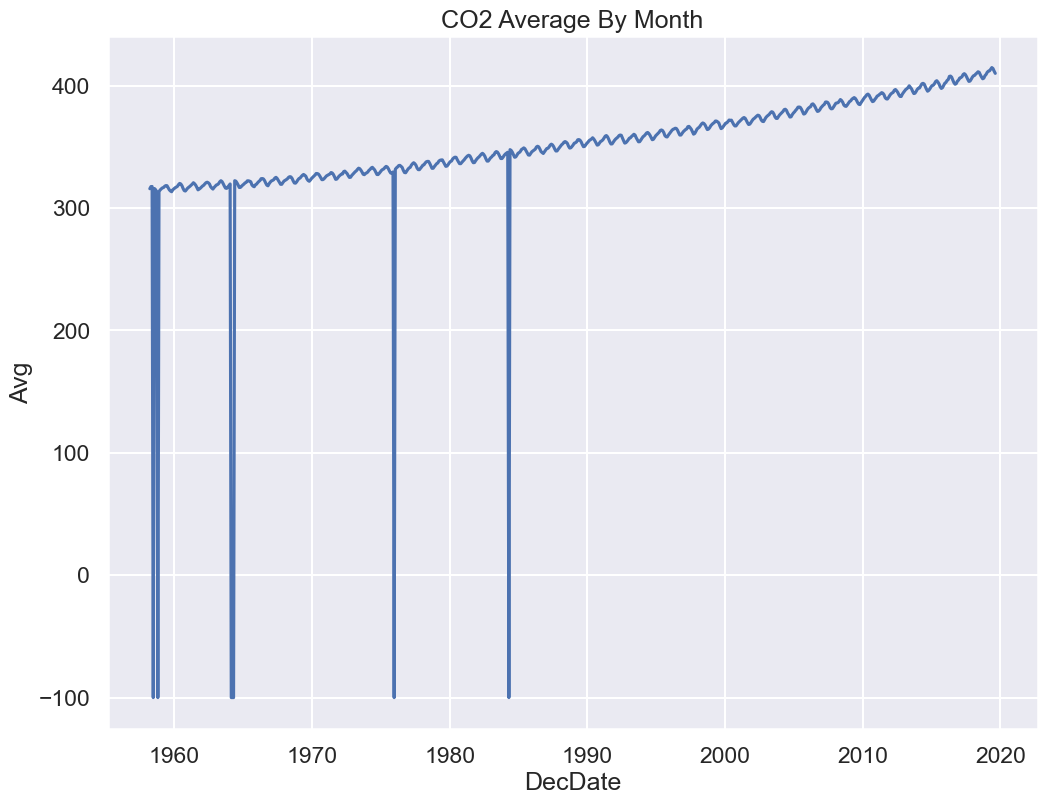

In [48]:
#| fig-alt: A lineplot of the monthly averages from the 1960s to the 1980s. The data mostly has a repeating wave pattern and is larger as time goes on. However, there are a number of large dips to -100.
sns.lineplot(x='DecDate', y='Avg', data=co2)
plt.title("CO2 Average By Month");

Since we are plotting `Avg` vs `DecDate`, we should just focus on dealing with missing values for `Avg`.

Let's consider a few options:
1. Drop those records
2. Replace -99.99 with NaN
3. Substitute it with a likely value for the average CO<sub>2</sub>?

What do you think are the pros and cons of each possible action?

Let's examine each of these three options.

In [49]:
# 1. Drop missing values
co2_drop = co2[co2['Avg'] > 0]
co2_drop.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1
5,1958,8,1958.62,314.93,314.93,315.94,-1


In [50]:
# 2. Replace NaN with -99.99
co2_NA = co2.replace(-99.99, np.nan)
co2_NA.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,NaN,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


We'll also use a third version of the data.

First, we note that the dataset already comes with a **substitute value** for the -99.99.

From the file description:

>  The `interpolated` column includes average values from the preceding column (`average`)
and **interpolated values** where data are missing.  Interpolated values are
computed in two steps...

The `Int` feature has values that exactly match those in `Avg`, except when `Avg` is -99.99, and then a **reasonable** estimate is used instead.

So, the third version of our data will use the `Int` feature instead of `Avg`.

In [51]:
# 3. Use interpolated column which estimates missing Avg values
co2_impute = co2.copy()
co2_impute['Avg'] = co2['Int']
co2_impute.head()

,Yr,Mo,DecDate,Avg,Int,Trend,Days
0,1958,3,1958.21,315.71,315.71,314.62,-1
1,1958,4,1958.29,317.45,317.45,315.29,-1
2,1958,5,1958.38,317.50,317.50,314.71,-1
3,1958,6,1958.46,317.10,317.10,314.85,-1
4,1958,7,1958.54,315.86,315.86,314.98,-1


What's a **reasonable** estimate?

To answer this question, let's zoom in on a short time period, say the measurements in 1958 (where we know we have two missing values).

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: "Three plots are shown with overall title 'Monthly Averages for 1958.' The first plot is 'Drop Missing' where the datapoints for x=6 and x=10 are not shown, but the datapoints are connected with lines. The second plot is 'Missing Set to NaN' where the lines are segmented from 3 to 5, 7 to 9, and 11 to 12. The third plot is 'Missing Interpolated' where we see the missing datapoints at x=6 and x=10 are now imputed following the shape of the other data."
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # axssumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()
```
````

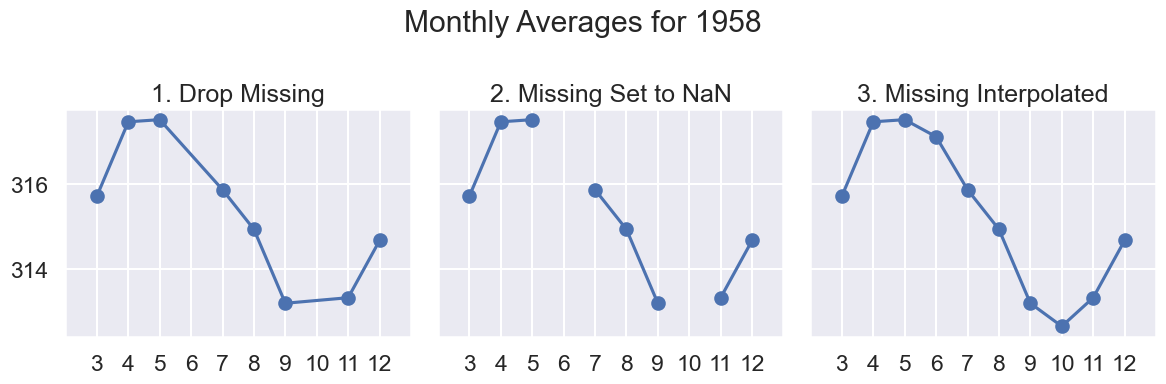

In [52]:
#| fig-alt: "Three plots are shown with overall title 'Monthly Averages for 1958.' The first plot is 'Drop Missing' where the datapoints for x=6 and x=10 are not shown, but the datapoints are connected with lines. The second plot is 'Missing Set to NaN' where the lines are segmented from 3 to 5, 7 to 9, and 11 to 12. The third plot is 'Missing Interpolated' where we see the missing datapoints at x=6 and x=10 are now imputed following the shape of the other data."
# results of plotting data in 1958

def line_and_points(data, ax, title):
    # axssumes single year, hence Mo
    ax.plot('Mo', 'Avg', data=data)
    ax.scatter('Mo', 'Avg', data=data)
    ax.set_xlim(2, 13)
    ax.set_title(title)
    ax.set_xticks(np.arange(3, 13))

def data_year(data, year):
    return data[data["Yr"] == 1958]
    
# uses matplotlib subplots
# you may see more next week; focus on output for now
fig, axes = plt.subplots(ncols = 3, figsize=(12, 4), sharey=True)

year = 1958
line_and_points(data_year(co2_drop, year), axes[0], title="1. Drop Missing")
line_and_points(data_year(co2_NA, year), axes[1], title="2. Missing Set to NaN")
line_and_points(data_year(co2_impute, year), axes[2], title="3. Missing Interpolated")

fig.suptitle(f"Monthly Averages for {year}")
plt.tight_layout()

In the big picture since there are only 7 `Avg` values missing (**<1%** of 738 months), any of these approaches would work.

However there is some appeal to **option C, Imputing**:

* Shows seasonal trends for CO<sub>2</sub>
* We are plotting all months in our data as a line plot


Let's replot our original figure with option 3:

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: Plot titled CO2 averages by month, imputed. Now the data follows a repeating wave pattern while also increasing as the years increase.
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");
```
````

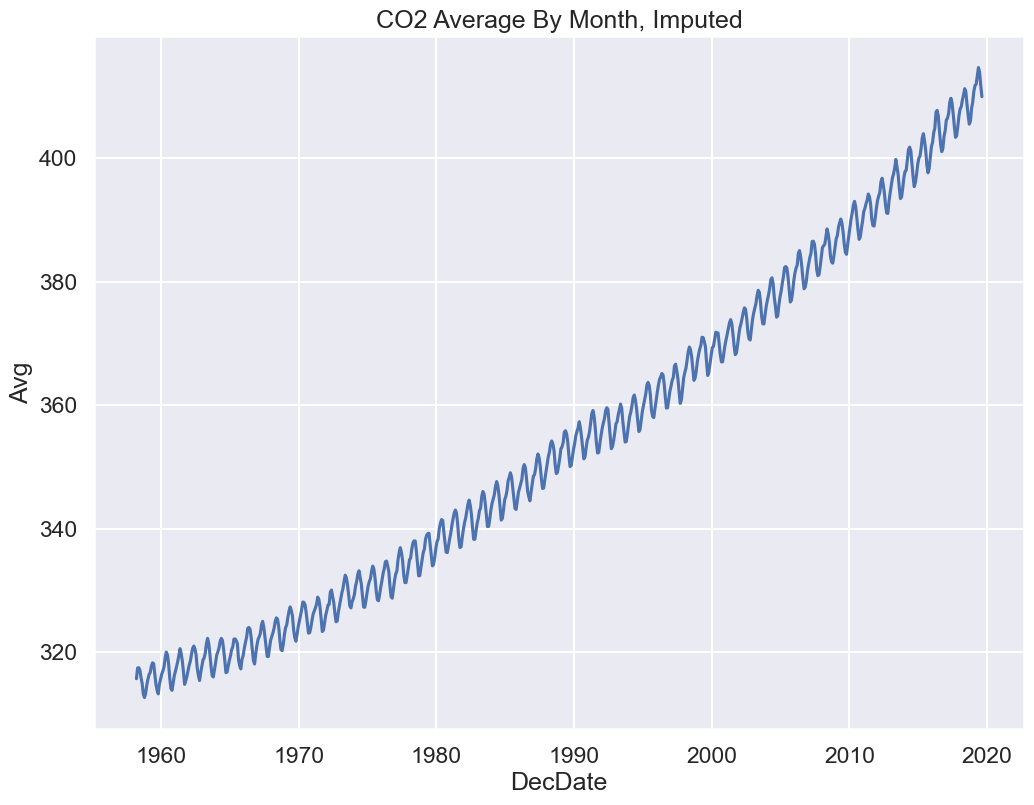

In [53]:
#| fig-alt: Plot titled CO2 averages by month, imputed. Now the data follows a repeating wave pattern while also increasing as the years increase.
sns.lineplot(x='DecDate', y='Avg', data=co2_impute)
plt.title("CO2 Average By Month, Imputed");

Looks pretty close to what we see on the NOAA [website](https://gml.noaa.gov/ccgg/trends/)!

### Presenting the Data: A Discussion on Data Granularity

From the description:

* Monthly measurements are averages of average day measurements.
* The NOAA GML website has datasets for daily/hourly measurements too.

The data you present depends on your research question.

**How do CO<sub>2</sub> levels vary by season?**

* You might want to keep average monthly data.

**Are CO<sub>2</sub> levels rising over the past 50+ years, consistent with global warming predictions?**

* You might be happier with a **coarser granularity** of average year data!

````{dropdown} Click to see the code
:open: false
```
#| fig-alt: CO2 Average by Year. The line steadily increases from about y = 320 to over 400.
co2_year = co2_impute.groupby('Yr').mean()
sns.lineplot(x='Yr', y='Avg', data=co2_year)
plt.title("CO2 Average By Year");
```
````

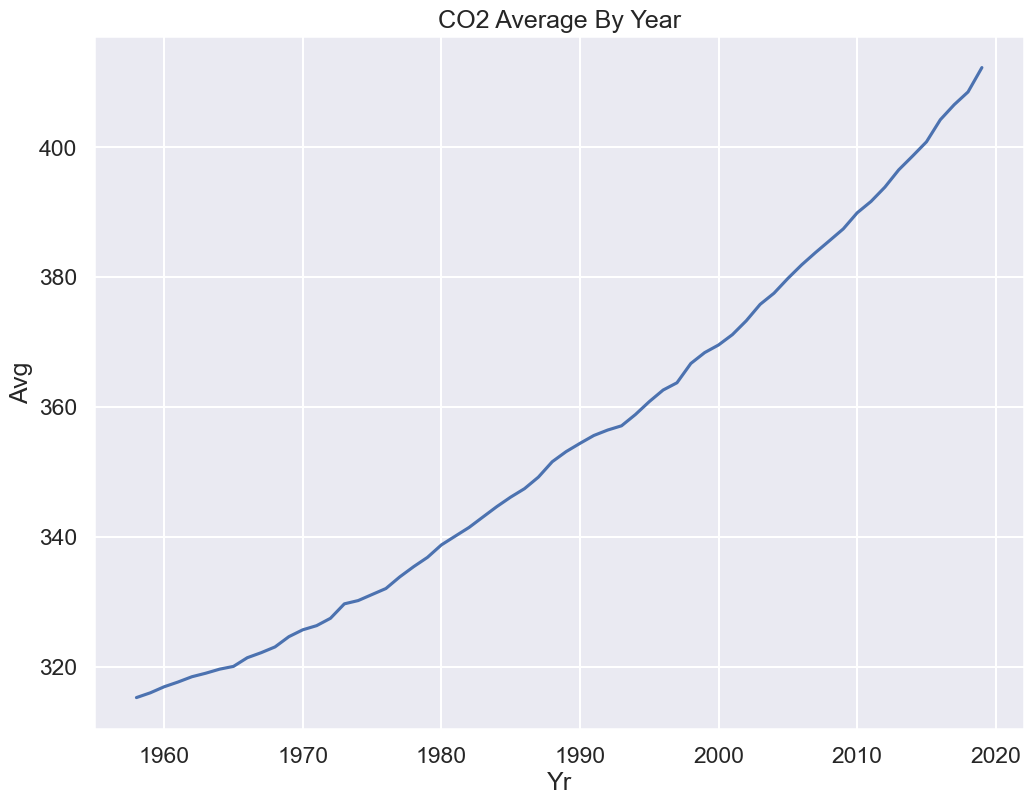

In [54]:
#| fig-alt: CO2 Average by Year. The line steadily increases from about y = 320 to over 400.
co2_year = co2_impute.groupby('Yr').mean()
sns.lineplot(x='Yr', y='Avg', data=co2_year)
plt.title("CO2 Average By Year");

Indeed, we see a rise by nearly 100 ppm of CO<sub>2</sub> since Mauna Loa began recording in 1958.